### 3a) Training 16 full supported variants that received non-zero weights from decision-tree like models using the stratified k-fold and GridSearchCV Hyper-parameters.

Note: The analysis displayed here is only for 16 full supported variants in stratified fold 1 (i.e., 80 % training and 20 % testing). This Jupyter notebook script was further re-cycled 4-times to account for ML analyses in stratified folds 2 - 5 datasets.

In [1]:
# import numpy as np
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import collections

#### Classifier Libraries
import xgboost as xgb
from sklearn.svm import SVC, LinearSVC
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_validate, StratifiedKFold
import sys, os,gzip,operator,glob, math, csv
import numpy as np
from scipy import stats
from statsmodels.sandbox.stats.multicomp import fdrcorrection0
from scipy.cluster.hierarchy import linkage,dendrogram,ward
import scipy.spatial.distance as ssd

### Other Libraries
from statistics import mean, stdev
from sklearn import preprocessing, linear_model
from sklearn.model_selection import train_test_split, StratifiedShuffleSplit, GridSearchCV, cross_val_score
from sklearn.metrics import accuracy_score, f1_score, auc, roc_auc_score, roc_curve, precision_recall_curve, matthews_corrcoef
from sklearn.preprocessing import StandardScaler,RobustScaler, label_binarize
from sklearn.pipeline import make_pipeline
from imblearn.pipeline import make_pipeline as imbalanced_make_pipeline
from imblearn.over_sampling import SMOTE, ADASYN
from sklearn.metrics import make_scorer, precision_score, recall_score, classification_report, confusion_matrix
from collections import Counter
import warnings
warnings.filterwarnings("ignore")


#### Import Datasets (5-Folds 80 % training & 20 % testing datasets)

In [2]:
# import the training and test set feature count matrices

fs="\t"
path="/Users/Hp/Desktop/2000_cohort_datasets_analysis/"

# assign dataset names
list_of_names = ['featurecount_fold_1_16_full_support_variants_with_covariates_train','featurecount_fold_1_16_full_support_variants_with_covariates_test', 
                 'featurecount_fold_2_16_full_support_variants_with_covariates_train','featurecount_fold_2_16_full_support_variants_with_covariates_test', 
                'featurecount_fold_3_16_full_support_variants_with_covariates_train','featurecount_fold_3_16_full_support_variants_with_covariates_test',  
                 'featurecount_fold_4_16_full_support_variants_with_covariates_train','featurecount_fold_4_16_full_support_variants_with_covariates_test',
                'featurecount_fold_5_16_full_support_variants_with_covariates_train', 'featurecount_fold_5_16_full_support_variants_with_covariates_test']
 
# create empty list
dataframes_list = []
 
# append datasets into the list
for i in range(len(list_of_names)):
    df = pd.read_csv(path+list_of_names[i]+".csv", delimiter=',', quotechar='"', index_col='sample_ID')
    dataframes_list.append(df)

#### Define training and testing sets

In [3]:
# define train and testing list 
train_list = [dataframes_list[0], dataframes_list[2], dataframes_list[4], 
                      dataframes_list[6], dataframes_list[8]]

test_list = [dataframes_list[1], dataframes_list[3], dataframes_list[5], 
                     dataframes_list[7], dataframes_list[9]]

In [4]:
train_list[0].head()

,age,gender,grouping,BMS1P1;FRMPD2B,CEP131,CNTFR,GFM1,GOLGA6L3,HDGFL2,LOC100996720,MIR933,PCSK5,PLEC,SECISBP2L,SPATA6,TRIM72,ZBED3,ZBTB3,ZRANB3
sample_ID,,,,,,,,,,,,,,,,,,,
AR-COV-10_hg38,79,0,1,0,2,0,0,1,0,0,0,0,0,0,1,0,0,0,0
AR-COV-11_hg38,62,1,1,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0
AR-COV-14_hg38,70,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
AR-COV-15_hg38,51,1,1,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0
AR-COV-18_hg38,48,0,1,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [5]:
# Define features and targets training and testing sets all 5-folds 
features_train = []
features_test = []

target_train = []
target_test = []

# target 
for df in train_list:
#for df in train_list:
    y_tr = df[['grouping']]
#convert dataframe to arrary
    target_train.append(y_tr)
    y_tr.values
for ds in test_list:
    y_ts = ds[['grouping']]
    target_test.append(y_ts)
    y_ts.values

# features 
for df in train_list:
        df.drop('grouping', axis = 1, inplace=True)
        df.values
        features_train.append(df)
for ds in test_list:
        ds.drop('grouping', axis = 1, inplace=True)
        #convert dataframe to arrary 
        ds.values
        features_test.append(ds)

In [6]:
features_train[0]

,age,gender,BMS1P1;FRMPD2B,CEP131,CNTFR,GFM1,GOLGA6L3,HDGFL2,LOC100996720,MIR933,PCSK5,PLEC,SECISBP2L,SPATA6,TRIM72,ZBED3,ZBTB3,ZRANB3
sample_ID,,,,,,,,,,,,,,,,,,
AR-COV-10_hg38,79,0,0,2,0,0,1,0,0,0,0,0,0,1,0,0,0,0
AR-COV-11_hg38,62,1,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0
AR-COV-14_hg38,70,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
AR-COV-15_hg38,51,1,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0
AR-COV-18_hg38,48,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
SPC-COV-6_hg38,86,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0
SPL-COV-2_hg38,73,1,0,2,1,0,0,0,0,0,0,0,0,0,0,0,0,0
USCA1-VALTIBERINA2_hg38,57,0,0,2,0,0,0,0,2,0,1,0,0,0,1,0,0,0


#### Standardized features in all 5-folds 

In [7]:
scaler1 = StandardScaler()
scaler2 = StandardScaler()
scaler3 = StandardScaler()
scaler4 = StandardScaler()
scaler5 = StandardScaler()
df1 = features_train[0] # train set fold 1
df2 = features_test[0] # test set fold 1

df1= scaler1.fit_transform(df1) # normalize df1 and df2
df2 = scaler1.transform(df2)

df3 = features_train[1] # train set fold 2
df4 = features_test[1] # test set fold 2

df3= scaler2.fit_transform(df3) # normalize df3 and df4
df4 = scaler2.transform(df4)

df5 = features_train[2] # train set fold 3
df6 = features_test[2] # test set fold 3

df5 = scaler3.fit_transform(df5) # normalize df5 and df6
df6 = scaler3.transform(df6)

df7 = features_train[3] # train set fold 4
df8 = features_test[3] # test set fold 4

df7= scaler4.fit_transform(df7) # normalize df7 and df8
df8 = scaler4.transform(df8)

df9 = features_train[4] # train set fold 5
df10 = features_test[4] # test set fold 5

df9= scaler5.fit_transform(df9) # normalize df9 and df10
df10 = scaler5.transform(df10)

In [8]:
### start by fitting fold 1 

X_train = df1     # train set fold 1
X_test = df2     # test set fold 1

y_train = target_train[0].values   # target train fold 1
y_test = target_test[0].values     # target test fold 1


In [9]:
# Create   classifiers object: 
svm = SVC(C=1, class_weight='balanced', kernel='linear', probability=True)

lr = LogisticRegression(C=0.3, class_weight='balanced', random_state=42,solver='sag')

rf = RandomForestClassifier(class_weight='balanced', max_depth=80, max_features=2,
                       min_samples_leaf=3, min_samples_split=10,
                       n_estimators=300)

# import XGBoost
import xgboost as xgboost

# define data_dmatrix
data_dmatrix = xgb.DMatrix(data=X_train,label=y_train)
xgboost = XGBClassifier(class_weight='balanced', objective="binary:logistic", random_state=42)

In [10]:
## Defined Cross-validation K-fold random Split 
from sklearn.model_selection import RepeatedKFold
cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)

#### Define GridSearchCV Hyper-parameters

In [11]:
## SVC classifier 
clf = svm
# declare parameters for hyperparameter tuning
params_svc = [{'C':[1, 10, 100, 1000], 'kernel':['linear']},
               {'C':[1, 10, 100, 1000], 'kernel':['rbf'], 'gamma':[0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]},
               {'C':[1, 10, 100, 1000], 'kernel':['poly'], 'degree': [2,3,4] ,'gamma':[0.01,0.02,0.03,0.04,0.05]} 
              ]

## Logistic Regression 
clf = lr
params_log = [{
    'solver': ['newton-cg', 'lbfgs', 'sag'],
    'C': [0.3, 0.5, 0.7, 1],
    'penalty': ['l2']
    },{
    'solver': ['liblinear','saga'],
    'C': [0.3, 0.5, 0.7, 1],
    'penalty': ['l1','l2']
}]

##  Random Forest 
#hyper parameters set
params_rf = {
    'bootstrap': [True],
    'max_depth': [80, 90, 100, 110],
    'max_features': [2, 3],
    'min_samples_leaf': [3, 4, 5],
    'min_samples_split': [8, 10, 12],
    'n_estimators': [50, 100, 300]}

### XGBoost Classifier 
# Hyper-parameters set 
params_xgboost = {
    'max_depth': range (2, 10, 1),
    'n_estimators': range(60, 220, 40),
    'learning_rate': [0.1, 0.01, 0.05]}


# SVC Gridsearch CV 
cv_grid_svm = GridSearchCV(estimator = svm,  
                           param_grid = params_svc,
                           scoring=make_scorer(accuracy_score),
                           cv = cv,
                           verbose=0)

# Logistic Reg. Gridsearch CV 
cv_grid_lr = GridSearchCV(
    estimator=lr,
    param_grid=params_log,
    n_jobs=-1,
    cv = cv, 
    scoring=make_scorer(accuracy_score)
)

# Random Forest Gridsearch CV  
cv_grid_rf = GridSearchCV(
    estimator=rf,
    param_grid=params_rf,
    n_jobs=-1,
    cv = cv,
    scoring=make_scorer(accuracy_score)
)

# XGBoost classifier GridSearch CV 
cv_grid_xgboost = GridSearchCV(
    estimator=xgboost,
    param_grid=params_xgboost,
    n_jobs=10,
    cv = cv,
    verbose=True,
    scoring=make_scorer(accuracy_score)
)

#### Fit ML Models Fold 1 - 5

#### 1) SVC model 

In [12]:
### Fit Models using Best Grid Search CV Parameters 
svm_model_cv = cv_grid_svm.fit(X_train, y_train)
# SVC Best GridSearch CV Best score 
print('SVC Best GridSearch CV Score:', svm_model_cv.best_score_)

SVC Best GridSearch CV Score: 0.8059628328943518


In [13]:
### Validation of Model classifiers on 20 % test set in each fold 
# Support Vector Classifier 
y_predict_svm = svm_model_cv.predict(X_test)
accuracy = accuracy_score(y_test,y_predict_svm)
print('accuracy of the best classifier after CV is %.3f%%' % (accuracy*100))

accuracy of the best classifier after CV is 76.331%


**Test set performance metrics report** 

Test Matthews correlation coefficient 0.5110711241406442
Test F1- score 0.8058252427184465
Test Precision score 0.8556701030927835
Test Recall score 0.7614678899082569
              precision    recall  f1-score   support

           0       0.64      0.77      0.70        60
           1       0.86      0.76      0.81       109

    accuracy                           0.76       169
   macro avg       0.75      0.76      0.75       169
weighted avg       0.78      0.76      0.77       169



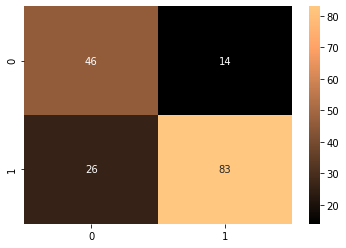

In [14]:
#Classification reports SVC 
print('Test Matthews correlation coefficient %s' % matthews_corrcoef(y_test, y_predict_svm))
print('Test F1- score %s' % f1_score(y_test, y_predict_svm))
print('Test Precision score %s' % precision_score(y_test, y_predict_svm))
print('Test Recall score %s' % recall_score(y_test, y_predict_svm))
print(classification_report(y_test, y_predict_svm))
confusion_matrix(y_test, y_predict_svm)
conf_matrix = confusion_matrix(y_test,y_predict_svm)
sns.heatmap(conf_matrix, annot=True,fmt='d', cmap=plt.cm.copper)
plt.show()

#### 2) Logistic Regression Model 

In [15]:
### Fit Models using Best Grid Search CV Parameters
log_reg_model_cv = cv_grid_lr.fit(X_train, y_train)
# Logistic Reg. Best GridSearch CV Best score 
print('Logistic Reg. Best GridSearch CV Score:', log_reg_model_cv.best_score_)

Logistic Reg. Best GridSearch CV Score: 0.8099209833187007


In [16]:
### Validation of Model classifiers on 20 % test set in each fold 
# Logistic Regression Classifier 
y_predict_log = log_reg_model_cv.predict(X_test)
accuracy = accuracy_score(y_test,y_predict_log)
print('accuracy_score of the best classifier after CV is %.3f%%' % (accuracy*100))

accuracy_score of the best classifier after CV is 75.148%


Test Matthews correlation coefficient 0.4860650384487597
Test F1- score 0.796116504854369
Test Precision score 0.845360824742268
Test Recall score 0.7522935779816514
              precision    recall  f1-score   support

           0       0.62      0.75      0.68        60
           1       0.85      0.75      0.80       109

    accuracy                           0.75       169
   macro avg       0.74      0.75      0.74       169
weighted avg       0.77      0.75      0.76       169



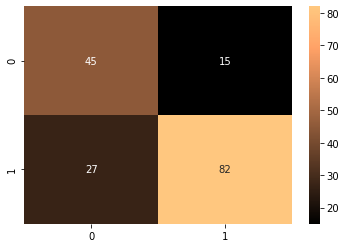

In [17]:
#Classification reports Logreg
print('Test Matthews correlation coefficient %s' % matthews_corrcoef(y_test, y_predict_log))
print('Test F1- score %s' % f1_score(y_test, y_predict_log))
print('Test Precision score %s' % precision_score(y_test, y_predict_log))
print('Test Recall score %s' % recall_score(y_test, y_predict_log))
print(classification_report(y_test, y_predict_log))
confusion_matrix(y_test, y_predict_log)
conf_matrix = confusion_matrix(y_test,y_predict_log)
sns.heatmap(conf_matrix, annot=True,fmt='d', cmap=plt.cm.copper)
plt.show()

#### 3) Random Forest Model 

In [18]:
## Random Forest Model 
rf_model_cv  = cv_grid_rf.fit(X_train, y_train)
# Random Forest Best GridSearch CV Best score 
print('Random Forest Best GridSearch CV Score: ', rf_model_cv.best_score_)

Random Forest Best GridSearch CV Score:  0.7900863330406788


In [19]:
### validation of Best Grid Search CV model on test set
# Random Forest Classifier 
y_predict_rf = rf_model_cv.predict(X_test)
accuracy = accuracy_score(y_test,y_predict_rf)
print('accuracy_score of the best classifier after CV is %.3f%%' % (accuracy*100))

accuracy_score of the best classifier after CV is 77.515%


Test Accuracy score 0.7751479289940828
Test Matthews correlation coefficient 0.5308832911380296
Test F1- score 0.8173076923076924
Test Precision score 0.8585858585858586
Test Recall score 0.7798165137614679
              precision    recall  f1-score   support

           0       0.66      0.77      0.71        60
           1       0.86      0.78      0.82       109

    accuracy                           0.78       169
   macro avg       0.76      0.77      0.76       169
weighted avg       0.79      0.78      0.78       169



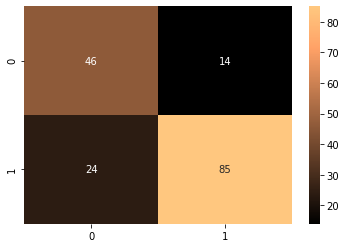

In [20]:
#Classification reports Random Forest 
print('Test Accuracy score %s' % accuracy_score(y_test, y_predict_rf))
print('Test Matthews correlation coefficient %s' % matthews_corrcoef(y_test, y_predict_rf))
print('Test F1- score %s' % f1_score(y_test, y_predict_rf))
print('Test Precision score %s' % precision_score(y_test, y_predict_rf))
print('Test Recall score %s' % recall_score(y_test, y_predict_rf))
print(classification_report(y_test, y_predict_rf))
confusion_matrix(y_test, y_predict_rf)
conf_matrix = confusion_matrix(y_test,y_predict_rf)
sns.heatmap(conf_matrix, annot=True,fmt='d', cmap=plt.cm.copper)
plt.show()

#### 4) XGBOOST Model 

In [21]:
## XGboost Model 
xgboost_model_cv  = cv_grid_xgboost.fit(X_train, y_train)
# XGBoost Best GridSearch CV Best score 
print('XGBoost Best GridSearch CV Score: ', xgboost_model_cv.best_score_)

Fitting 30 folds for each of 96 candidates, totalling 2880 fits


[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    3.7s
[Parallel(n_jobs=10)]: Done 180 tasks      | elapsed:    7.7s
[Parallel(n_jobs=10)]: Done 430 tasks      | elapsed:   15.4s
[Parallel(n_jobs=10)]: Done 780 tasks      | elapsed:   29.6s
[Parallel(n_jobs=10)]: Done 1230 tasks      | elapsed:   46.2s
[Parallel(n_jobs=10)]: Done 1780 tasks      | elapsed:  1.2min
[Parallel(n_jobs=10)]: Done 2430 tasks      | elapsed:  1.5min
[Parallel(n_jobs=10)]: Done 2880 out of 2880 | elapsed:  1.9min finished


XGBoost Best GridSearch CV Score:  0.8005414105940886


In [22]:
### validation of Best Grid Search CV model on test set
y_predict_xgboost = xgboost_model_cv.predict(X_test)
accuracy = accuracy_score(y_test,y_predict_xgboost)
print('accuracy_score of the best classifier after CV is %.3f%%' % (accuracy*100))


accuracy_score of the best classifier after CV is 76.923%


Test Accuracy score 0.7692307692307693
Test Matthews correlation coefficient 0.5158100734869863
Test F1- score 0.8133971291866028
Test Precision score 0.85
Test Recall score 0.7798165137614679
              precision    recall  f1-score   support

           0       0.65      0.75      0.70        60
           1       0.85      0.78      0.81       109

    accuracy                           0.77       169
   macro avg       0.75      0.76      0.76       169
weighted avg       0.78      0.77      0.77       169



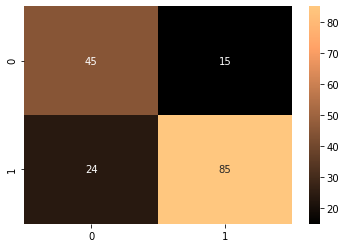

In [23]:
#Classification reports XGBoost classifier  
print('Test Accuracy score %s' % accuracy_score(y_test, y_predict_xgboost))
print('Test Matthews correlation coefficient %s' % matthews_corrcoef(y_test, y_predict_xgboost))
print('Test F1- score %s' % f1_score(y_test, y_predict_xgboost))
print('Test Precision score %s' % precision_score(y_test, y_predict_xgboost))
print('Test Recall score %s' % recall_score(y_test, y_predict_xgboost))
print(classification_report(y_test, y_predict_xgboost))
confusion_matrix(y_test, y_predict_xgboost)
conf_matrix = confusion_matrix(y_test,y_predict_xgboost)
sns.heatmap(conf_matrix, annot=True,fmt='d', cmap=plt.cm.copper)
plt.show()

#### ROC/AUC Curve interpretations

**SVC Classifier**

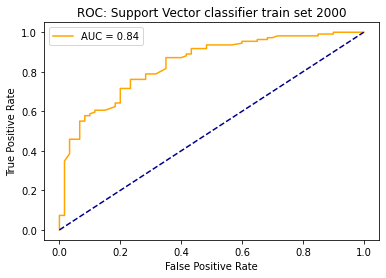

In [24]:
# Now plot the ROC curve for SVC Classifier 
probs = svm_model_cv.predict_proba(X_test)
probs = probs[:, 1]
auc = roc_auc_score(y_test, probs)
fpr, tpr, thresholds = roc_curve(y_test, probs)

def plot_roc_curve(fpr, tpr):
    plt.plot(fpr, tpr, color='orange', label = 'AUC = %0.2f' % auc)
    plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC: Support Vector classifier train set 2000')
    plt.legend()
    plt.show()
plot_roc_curve(fpr, tpr)


**Logistic Regression**

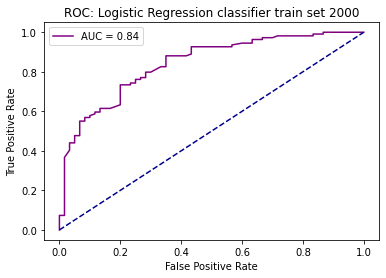

In [25]:
probs_1 = log_reg_model_cv.predict_proba(X_test)
probs_1 = probs_1[:, 1]
auc_1 = roc_auc_score(y_test, probs_1)
fpr_1, tpr_1, thresholds = roc_curve(y_test, probs_1)
def plot_roc_curve(fpr_1, tpr_1):
    plt.plot(fpr_1, tpr_1, color='purple', label = 'AUC = %0.2f' % auc_1)
    plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC: Logistic Regression classifier train set 2000')
    plt.legend()
    plt.show()
plot_roc_curve(fpr_1, tpr_1)

**Random Forest**

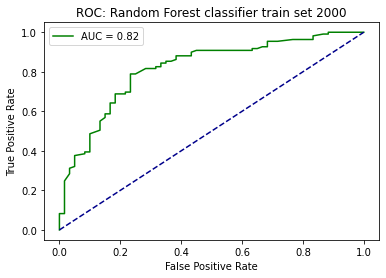

In [26]:
probs_2 = rf_model_cv.predict_proba(X_test)
probs_2 = probs_2[:, 1]
auc_2 = roc_auc_score(y_test, probs_2)
fpr_2, tpr_2, thresholds = roc_curve(y_test, probs_2)
def plot_roc_curve(fpr_2, tpr_2):
    plt.plot(fpr_2, tpr_2, color='green', label = 'AUC = %0.2f' % auc_2)
    plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC: Random Forest classifier train set 2000')
    plt.legend()
    plt.show()
plot_roc_curve(fpr_2, tpr_2)

**XGBoost**

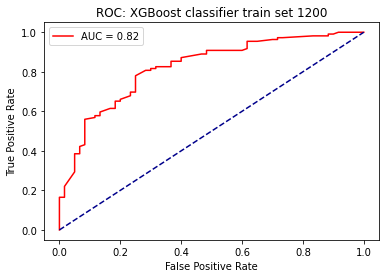

In [27]:
probs_3 = xgboost_model_cv.predict_proba(X_test)
probs_3 = probs_3[:, 1]
auc_3 = roc_auc_score(y_test, probs_3)
fpr_3, tpr_3, thresholds = roc_curve(y_test, probs_3)
def plot_roc_curve(fpr_3, tpr_3):
    plt.plot(fpr_3, tpr_3, color='red', label = 'AUC = %0.2f' % auc_3)
    plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC: XGBoost classifier train set 1200')
    plt.legend()
    plt.show()
plot_roc_curve(fpr_3, tpr_3)

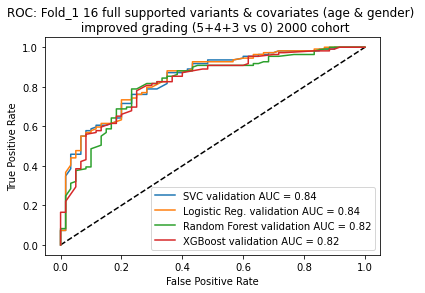

In [28]:
### Combine ROC curve for all the three classifiers SVC, Logistic Reg., Random Forest & XGBoost
plt.plot([0,1],[0,1], 'k--')
plt.plot(fpr, tpr, label = "SVC validation AUC = %0.2f" % auc)
plt.plot(fpr_1, tpr_1, label = "Logistic Reg. validation AUC = %0.2f" % auc_1)
plt.plot(fpr_2, tpr_2, label = "Random Forest validation AUC = %0.2f" % auc_2)
plt.plot(fpr_3, tpr_3, label = "XGBoost validation AUC = %0.2f" % auc_3)

plt.legend()
#place legend in top right corner
#plt.legend(bbox_to_anchor=(1,1), loc="upper left")
plt.legend(loc = 'lower right')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title('ROC: Fold_1 16 full supported variants & covariates (age & gender) \n improved grading (5+4+3 vs 0) 2000 cohort')
plt.savefig(path+'ROC_stratified_Fold_1_16_full_supported_2000_cohort.pdf')
plt.show()

#### Classifiers' Model importance

#### SVC Classifier 

In [29]:
# Identified best GridSearch CV Model parameters to evaluate feature importance of the models
df1 = features_train[0] 
df2 = pd.read_csv(path+"pheno_test_fold_1.csv")
# 1) SVC Classifier
svm_model_cv_linear = SVC(C=1, class_weight='balanced', degree=2, gamma=0.04, kernel='linear')

new_target_train = svm_model_cv.predict(X_train)

svm_model_cv_1 = svm_model_cv_linear.fit(X_train,new_target_train) 
#Analyzing the coefficients
importance_svm = pd.concat([pd.DataFrame(np.transpose(df1.columns), columns = ["Features"]),
           pd.DataFrame(np.transpose(svm_model_cv_1.coef_), columns = ["Importance"])
           ],axis = 1)
importance_svm.sort_values(by='Importance', ascending=False).head(10)
#save as CSV file 
importance_svm.to_csv(path + "SVC_importance_train_fold_1_full_support.csv", index = True)

# Save prediction for SVC classifier 
df_new  = df2[["sample_ID", "grouping"]]

# save the predictions from validation set for SVC 
new_target = y_predict_svm
df_2 = pd.DataFrame(np.transpose(new_target), columns = ["predicted_grouping"])
#concatenate dataframes
df_3 = pd.concat([df_new, df_2], axis=1)
df_3.sort_values(by='predicted_grouping', ascending=False).head(10)
#save as CSV file 
df_3.to_csv(path + "predictions_SVC_test_fold_1_full_support.csv", index = True)


#### Logistic Regression Classifier 

In [30]:
# 2) Logistic Regression classifier 
clf = log_reg_model_cv.best_estimator_
clf.fit(X_train, y_train)
#Analyzing the coefficients
importance_logreg = pd.concat([pd.DataFrame(np.transpose(df1.columns), columns = ["Features"]),
           pd.DataFrame(np.transpose(clf.coef_), columns = ["Importance"])
           ],axis = 1)
importance_logreg.sort_values(by='Importance', ascending=False).head(10)
#save as CSV file 
importance_logreg.to_csv("log_reg_importance_train_fold_1_full_support.csv", index = True)

# saving the predictions of Logistic Reg. classifier as new target
new_target = y_predict_log
df_4 = pd.DataFrame(np.transpose(new_target), columns = ["predicted_grouping"])
#concatenate dataframes
df_5 = pd.concat([df_new, df_4], axis=1)
#save as CSV file 
df_5.to_csv("prediction_log_reg_test_fold_1_full_support.csv", index = True)


#### Random Forest Classifier 

In [31]:
# 3) Random Forest 
# Use the best model hyper-parameter for Random Forest identified from CV grid search 
clf_rf = rf_model_cv.best_estimator_
clf_rf.fit(X_train, y_train)
#Analyzing the coefficients
importance_rf = pd.concat([pd.DataFrame(np.transpose(df1.columns), columns = ["Features"]),
           pd.DataFrame(np.transpose(clf_rf.feature_importances_), columns = ["Importance"])
           ],axis = 1)
importance_rf.sort_values(by='Importance', ascending=False).head(10)
#save as CSV file 
importance_rf.to_csv("Random_forest_importance_train_fold_1_full_support.csv", index = True)
# saving the predictions of Random Forest classifier as new target
new_target = y_predict_rf
df_6 = pd.DataFrame(np.transpose(new_target), columns = ["predicted_grouping"])
#concatenate dataframes
df_7 = pd.concat([df_new, df_6], axis=1)
#save as CSV file 
df_7.to_csv("prediction_Random_forest_test_fold_1_full_support.csv", index = True)

#### XGBoost Classifier 

In [32]:
# 4) XGBoost classifier 
# Use the best model hyper-parameter for XGBoost classifier identified from CV grid search 
clf_xgboost = xgboost_model_cv.best_estimator_
clf_xgboost.fit(X_train, y_train)
#Analyzing the coefficients
importance_xgboost = pd.concat([pd.DataFrame(np.transpose(df1.columns), columns = ["Features"]),
           pd.DataFrame(np.transpose(clf_xgboost.feature_importances_), columns = ["Importance"])
           ],axis = 1)
importance_xgboost.sort_values(by='Importance', ascending=False).head(10)
#save as CSV file 
importance_xgboost.to_csv("XGBoost_importance_train_fold_1_full_support.csv", index = True)
# saving the predictions of Random Forest classifier as new target
new_target = y_predict_xgboost
df_8 = pd.DataFrame(np.transpose(new_target), columns = ["predicted_grouping"])
#concatenate dataframes
df_9 = pd.concat([df_new, df_8], axis=1)
#save as CSV file 
df_9.to_csv("prediction_XGBoost_test_fold_1_full_support.csv", index = True)

#### Save ML best GridSearchCV training Models 

#### SVC Classifier model

In [33]:
# 1) save SVC Classifier model 
import joblib
model_svc_1200_improved = svm_model_cv
joblib.dump(svm_model_cv, path + 'model_svc_fold_1_full_support_2000_cohort')

['/Users/Hp/Desktop/2000_cohort_datasets_analysis/model_svc_fold_1_full_support_2000_cohort']

#### Logistic Regression Classifier model 

In [34]:
# 2) save model logistic Reg. classifier 

model_LOR_2000_improved = log_reg_model_cv  
joblib.dump(log_reg_model_cv, path + 'model_LOR_fold_1_full_support_2000_cohort')

['/Users/Hp/Desktop/2000_cohort_datasets_analysis/model_LOR_fold_1_full_support_2000_cohort']

#### Random Forest classifier model 

In [35]:
# 3) save model Random Forest classifier 

model_RF_2000_improved =rf_model_cv
joblib.dump(rf_model_cv, path + 'model_RF_fold_1_full_support_2000_cohort')

['/Users/Hp/Desktop/2000_cohort_datasets_analysis/model_RF_fold_1_full_support_2000_cohort']

#### XGBoost classifier model 

In [36]:
# 4) save model XGBoost classifier 

model_XGB_2000_improved = xgboost_model_cv  
joblib.dump(xgboost_model_cv, path + 'model_XGB_fold_1_full_support_2000_cohort')

['/Users/Hp/Desktop/2000_cohort_datasets_analysis/model_XGB_fold_1_full_support_2000_cohort']